## Data Loading

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV while excluding the "reference" column
df = pd.read_csv("Dataset.csv")

# Remove any row that's above threshold value
df = df[df["DC"] <=210]

# Drop the "reference" column if it exists
if "Reference" in df.columns:
    df = df.drop(columns=["Reference"])

# Display the dataframe
print(df.head())


  Element    Li     P    S  Dopant  AND   END    ARD   IRD       IC   LV   HV  \
0      Ge  3.25  0.75  4.0    0.25   32  2.01  1.225  0.53  0.00220  0.5  3.5   
1      Si  3.25  0.75  4.0    0.25   14  1.90  1.176  0.42  0.00064  0.5  3.5   
2      Cl  5.50  1.00  4.5    1.50   17  3.16  0.905  1.81  0.00680  1.9  4.2   
3      Cl  5.50  1.00  4.5    1.50   17  3.16  0.905  1.81  0.00680  1.9  4.2   
4      Cl  5.50  1.00  4.5    1.50   17  3.16  0.905  1.81  0.00680  1.9  4.2   

   Current   DC  
0  0.16744  126  
1  0.16744  120  
2  0.01000  130  
3  0.02000  113  
4  0.04000   95  


## Pearson Correlation

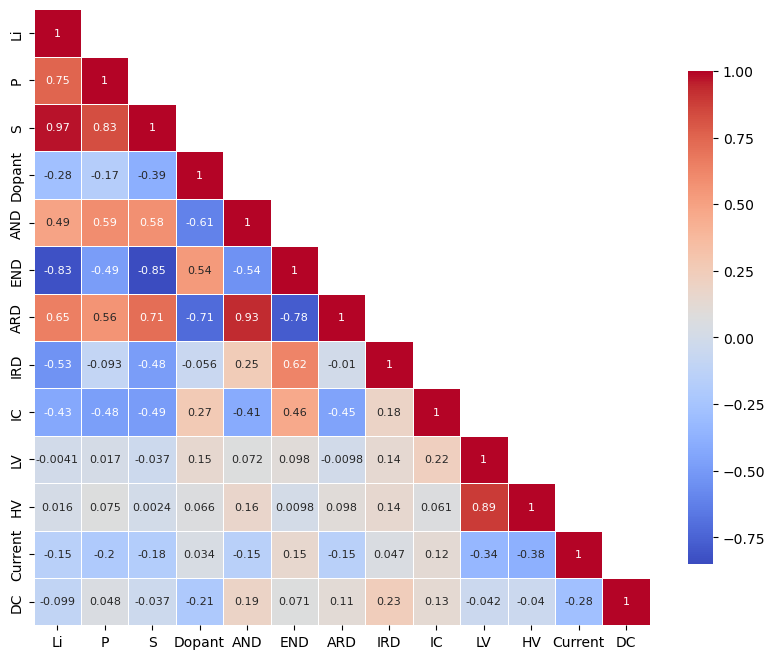

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Drop the "Element" column if it exists
temp_df = df.drop(columns=["Element"])

# Calculate the correlation matrix (Pearson by default)
corr_matrix = temp_df.corr()

# Create a mask for the upper triangle (excluding the diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # k=1 excludes the diagonal

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True, 
    cmap='coolwarm', 
    square=True, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8},
    annot_kws={"fontsize": 8}
)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

## XGBoost 

[I 2025-03-23 21:11:00,374] A new study created in memory with name: no-name-202c3aaf-53bf-4fca-bfa0-8995243aa283
[I 2025-03-23 21:11:01,253] Trial 0 finished with value: 0.42536258697509766 and parameters: {'n_estimators': 190, 'max_depth': 10, 'learning_rate': 0.11454303644862052, 'subsample': 0.7303209987549881, 'colsample_bytree': 0.9000564450048701, 'gamma': 3.907325064574489, 'reg_lambda': 3.8734463303213396, 'reg_alpha': 1.8926824022518947, 'min_child_weight': 7}. Best is trial 0 with value: 0.42536258697509766.
[I 2025-03-23 21:11:02,573] Trial 1 finished with value: 0.40433191061019896 and parameters: {'n_estimators': 299, 'max_depth': 7, 'learning_rate': 0.17007606067704864, 'subsample': 0.6309836994803463, 'colsample_bytree': 0.538323567743699, 'gamma': 0.2527749273220914, 'reg_lambda': 3.873821397780337, 'reg_alpha': 3.767088911969127, 'min_child_weight': 7}. Best is trial 0 with value: 0.42536258697509766.
[I 2025-03-23 21:11:03,673] Trial 2 finished with value: 0.30599983

Best params: {'n_estimators': 98, 'max_depth': 4, 'learning_rate': 0.22552792354473655, 'subsample': 0.7310734038128344, 'colsample_bytree': 0.5783487241760373, 'gamma': 4.719868698992134, 'reg_lambda': 0.13163568285358695, 'reg_alpha': 2.2728094309055225, 'min_child_weight': 4}
CSV test file saved successfully!
Evaluation Metrics:
{'Mean Squared Error (MSE)': 148.39748064755, 'Root Mean Squared Error (RMSE)': 12.181850460728452, 'Mean Absolute Error (MAE)': 9.008098971459173, 'R² Score': 0.8816349506378174, 'Adjusted R² Score': 0.8027249177296957}


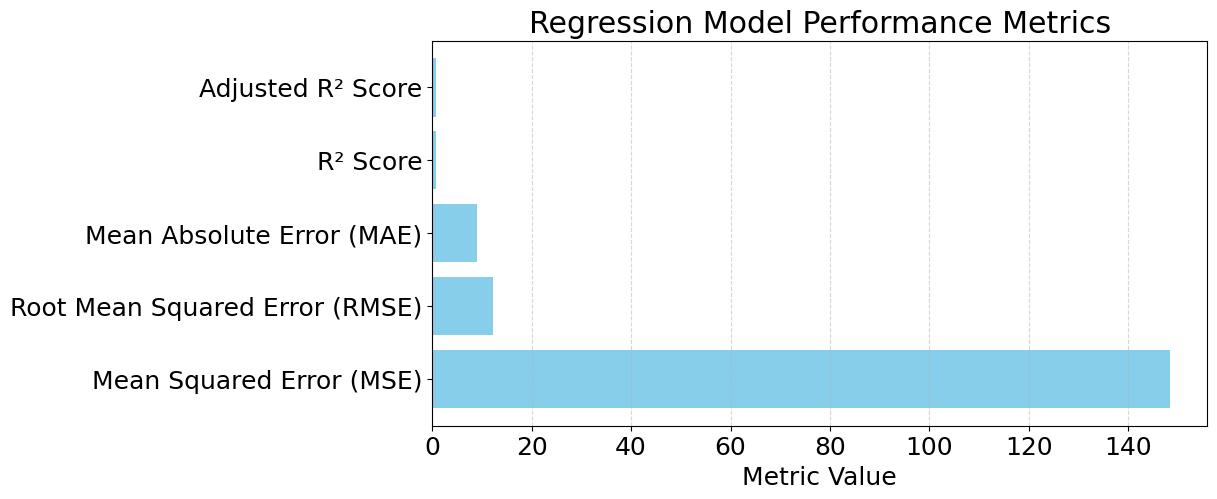

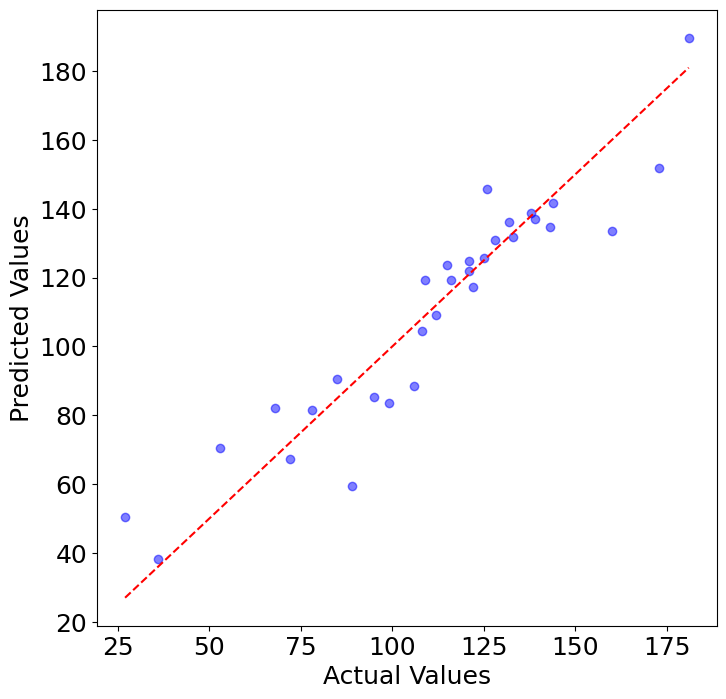

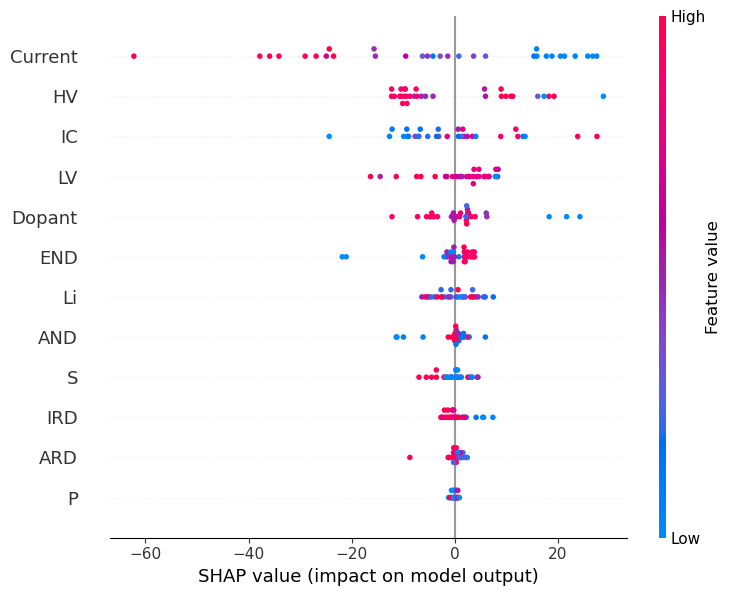

['Li', 'P', 'S', 'Dopant', 'AND', 'END', 'ARD', 'IRD', 'IC', 'LV', 'HV', 'Current']


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
import shap


# --- Preprocessing and Held-Out Test Split ---

# (Assume your DataFrame is already loaded as 'df')
# Remove the "Element" column if it exists
if "Element" in df.columns:
    df = df.drop(columns=["Element"])

# Define Features and Target
target_column = "DC"
# Save feature names for later use in SHAP plots
feature_names = df.drop(columns=[target_column]).columns.tolist()

X_full = df.drop(columns=[target_column]).to_numpy()  # convert to NumPy array
y_full = df[target_column].to_numpy()  # continuous target

# To enable stratification even for regression, we bin the target.
# Here we create 10 bins (you can adjust the number) using quantiles.
y_full_binned = pd.qcut(y_full, q=10, duplicates='drop', labels=False)

# Split into training+validation and held-out test sets (e.g., 85%/15%)
X_train_val, X_test, y_train_val, y_test, y_train_val_binned, _ = train_test_split(
    X_full, y_full, y_full_binned, test_size=0.15, random_state=42, stratify=y_full_binned
)

# --- Define the Objective Function with Stratified K-Fold CV ---

def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    # We'll use 5-fold stratified cross-validation.
    # For stratification in regression, we use the binned target.
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = []
    
    # Note: we need to bin the training targets for stratification. 
    # We already computed y_train_val_binned during the initial split.
    for train_index, val_index in skf.split(X_train_val, y_train_val_binned):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
        
        # For each fold, fit a scaler on the training fold only
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)
        
        # Train the model on the training fold
        model = XGBRegressor(**params, objective="reg:squarederror")
        model.fit(X_train_fold_scaled, y_train_fold, 
                  eval_set=[(X_val_fold_scaled, y_val_fold)], verbose=False)
        
        # Predict and calculate RMSE on the validation fold
        preds = model.predict(X_val_fold_scaled)
        r_squared = r2_score(y_val_fold, preds)
        r2_scores.append(r_squared)
    
    # Return the average R^2 over all folds
    return np.mean(r2_scores)

# --- Hyperparameter Optimization using Optuna ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# Retrieve the best hyperparameters
best_params = study.best_params
print(f"Best params: {best_params}")

# --- Final Model Training on Full Training Data (Train+Validation) ---
# Fit scaler on the entire training+validation set
scaler_final = StandardScaler()
X_train_val_scaled = scaler_final.fit_transform(X_train_val)
X_test_scaled = scaler_final.transform(X_test)

# Train the final model on all training+validation data
best_model = XGBRegressor(**best_params, objective="reg:squarederror")
best_model.fit(X_train_val_scaled, y_train_val)

y_pred_train_val = best_model.predict(X_train_val_scaled)
# --- Evaluate on Held-Out Test Set ---
y_pred = best_model.predict(X_test_scaled)

# Save predictions and ground truth
output_df = pd.DataFrame({'ground_truth': y_test, 'prediction': y_pred})
output_df.to_csv('output.csv', index=False)
print('CSV test file saved successfully!')

# Calculate adjusted R²
n = X_test.shape[0]
p = X_test.shape[1]

# Compute Evaluation Metrics
metrics = {
    "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred),
    "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
    "Mean Absolute Error (MAE)": mean_absolute_error(y_test, y_pred),
    "R² Score": r2_score(y_test, y_pred),
    "Adjusted R² Score": 1 - (1 - r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)
}

print("Evaluation Metrics:")
print(metrics)

# Plot the evaluation metrics as a bar chart
plt.figure(figsize=(10, 5))
plt.barh(list(metrics.keys()), list(metrics.values()), color='skyblue')
plt.xlabel("Metric Value")
plt.title("Regression Model Performance Metrics")
plt.grid(axis='x', linestyle="--", alpha=0.5)
plt.savefig("Metric_Values_Test.png")
plt.show()

# Plot Predictions vs Actual Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
# plt.scatter(y_pred_train_val, y_pred_train_val, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.savefig("XGB_Regression.png")
plt.show()

# --- SHAP Value Analysis ---

# Initialize SHAP's JS visualization (if running in a Jupyter Notebook)
shap.initjs()

# Create a TreeExplainer for the final model
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for the training+validation set (scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Generate a SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

print(feature_names)
# Optional: Generate a dependence plot for the most important feature (here, using the first feature)
#shap.dependence_plot(feature_names[7], shap_values, X_test_scaled, feature_names=feature_names)


## Support Vector Regression

[I 2025-03-23 21:13:02,471] A new study created in memory with name: no-name-d186ea45-b92e-4d8e-9356-20b2570425c9
[I 2025-03-23 21:13:02,508] Trial 0 finished with value: -3.4859723490370316 and parameters: {'kernel': 'poly', 'gamma_type': 'auto', 'C': 535.4027409612419, 'epsilon': 0.5955046457029883, 'degree': 4}. Best is trial 0 with value: -3.4859723490370316.
[I 2025-03-23 21:13:02,525] Trial 1 finished with value: -192.48620774688465 and parameters: {'kernel': 'sigmoid', 'gamma_type': 'scale', 'C': 341.71501644604456, 'epsilon': 0.578281714564863}. Best is trial 0 with value: -3.4859723490370316.
[I 2025-03-23 21:18:49,626] Trial 2 finished with value: -9272055.924371993 and parameters: {'kernel': 'poly', 'gamma_type': 'numeric', 'C': 555.8802917075391, 'epsilon': 0.7255579295722926, 'degree': 5, 'gamma': 1.6767497650036212}. Best is trial 0 with value: -3.4859723490370316.
[I 2025-03-23 21:18:49,668] Trial 3 finished with value: 0.39196366470280253 and parameters: {'kernel': 'rbf

Best params: {'kernel': 'rbf', 'gamma_type': 'numeric', 'C': 361.9161265619275, 'epsilon': 0.8125819035761888, 'gamma': 0.186496563880989}
CSV test file saved successfully!
Evaluation Metrics:
{'Mean Squared Error (MSE)': 433.8602527607079, 'Root Mean Squared Error (RMSE)': 20.829312344883302, 'Mean Absolute Error (MAE)': 11.694159211429668, 'R² Score': 0.6539437009449945, 'Adjusted R² Score': 0.4232395015749909}


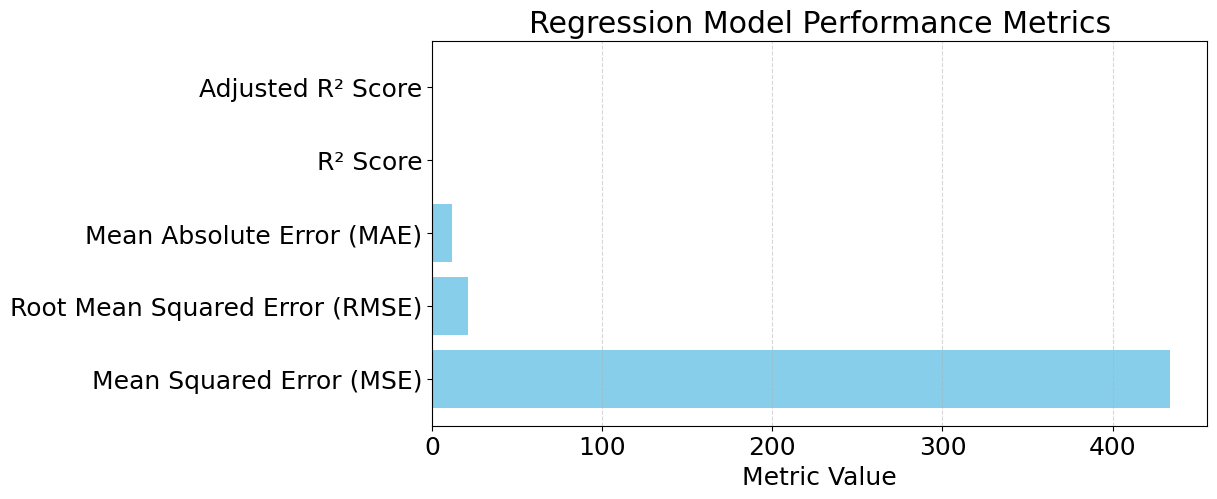

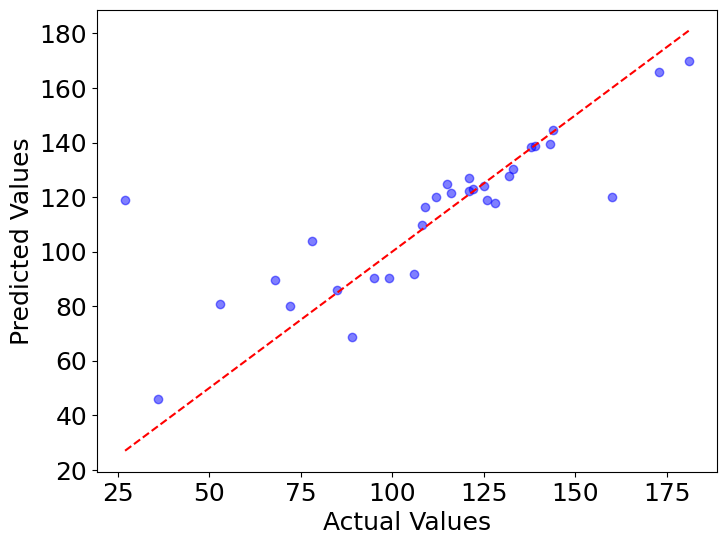

In [ ]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, StratifiedKFold

# --- Preprocessing and Held-Out Test Split ---

# (Assume your DataFrame is already loaded as 'df')
if "Element" in df.columns:
    df = df.drop(columns=["Element"])

target_column = "DC"
feature_names = df.drop(columns=[target_column]).columns.tolist()

X_full = df.drop(columns=[target_column]).to_numpy()
y_full = df[target_column].to_numpy()

y_full_binned = pd.qcut(y_full, q=10, duplicates='drop', labels=False)

X_train_val, X_test, y_train_val, y_test, y_train_val_binned, _ = train_test_split(
    X_full, y_full, y_full_binned, test_size=0.15, random_state=42, stratify=y_full_binned
)

# --- Define the Objective Function with Stratified K-Fold CV ---

def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma_type = trial.suggest_categorical('gamma_type', ['scale', 'auto', 'numeric'])
    
    params = {
        'C': trial.suggest_float('C', 0.1, 1000),
        'epsilon': trial.suggest_float('epsilon', 0.01, 1),
        'kernel': kernel
    }
    
    # Only add 'degree' when kernel is 'poly'
    if kernel == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 5)

    # Only add 'gamma' for non-linear kernels (rbf, poly, sigmoid)
    if kernel in ['rbf', 'poly', 'sigmoid']:
        if gamma_type == 'numeric':
            params['gamma'] = trial.suggest_float('gamma', 1e-4, 10)  # Suggested good range
        else:
            params['gamma'] = gamma_type  # 'scale' or 'auto'
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = []
    
    for train_index, val_index in skf.split(X_train_val, y_train_val_binned):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
        
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)
        
        model = SVR(**params)
        model.fit(X_train_fold_scaled, y_train_fold)
        
        preds = model.predict(X_val_fold_scaled)
        r_squared = r2_score(y_val_fold, preds)
        r2_scores.append(r_squared)
    
    return np.mean(r2_scores)

# --- Hyperparameter Optimization using Optuna ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

best_params = study.best_params
print(f"Best params: {best_params}")

best_params.pop('gamma_type')

# --- Final Model Training on Full Training Data ---
scaler_final = StandardScaler()
X_train_val_scaled = scaler_final.fit_transform(X_train_val)
X_test_scaled = scaler_final.transform(X_test)

best_model = SVR(**best_params)
best_model.fit(X_train_val_scaled, y_train_val)

y_pred = best_model.predict(X_test_scaled)

output_df = pd.DataFrame({'ground_truth': y_test, 'prediction': y_pred})
output_df.to_csv('output.csv', index=False)
print('CSV test file saved successfully!')

n = X_test.shape[0]
p = X_test.shape[1]

metrics = {
    "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred),
    "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
    "Mean Absolute Error (MAE)": mean_absolute_error(y_test, y_pred),
    "R² Score": r2_score(y_test, y_pred),
    "Adjusted R² Score": 1 - (1 - r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)
}

print("Evaluation Metrics:")
print(metrics)

plt.figure(figsize=(10, 5))
plt.barh(list(metrics.keys()), list(metrics.values()), color='skyblue')
plt.xlabel("Metric Value")
plt.title("Regression Model Performance Metrics")
plt.grid(axis='x', linestyle="--", alpha=0.5)
plt.savefig("Metric_Values_Test.png")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.savefig("Regresssion_SVR.png")
plt.show()

## Random Forest

[I 2025-03-13 14:55:27,643] A new study created in memory with name: no-name-4c9f3d0f-5656-441d-a8bb-29934e144cec
[I 2025-03-13 14:55:28,513] Trial 0 finished with value: 0.3792121289457177 and parameters: {'n_estimators': 113, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.3792121289457177.
[I 2025-03-13 14:55:29,485] Trial 1 finished with value: 0.3150579247315623 and parameters: {'n_estimators': 152, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.3792121289457177.
[I 2025-03-13 14:55:31,990] Trial 2 finished with value: 0.37282242011769373 and parameters: {'n_estimators': 401, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.3792121289457177.
[I 2025-03-13 14:55:33,719] Trial 3 finished with value: 0.3783630856857164 and parameters: {'n_estimators': 287, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with valu

Evaluation Metrics:
{'Mean Squared Error (MSE)': 382.26092283016004, 'Root Mean Squared Error (RMSE)': 19.551494132934188, 'Mean Absolute Error (MAE)': 12.99505544970442, 'R² Score': 0.7404872552256908, 'Adjusted R² Score': 0.5674787587094847}


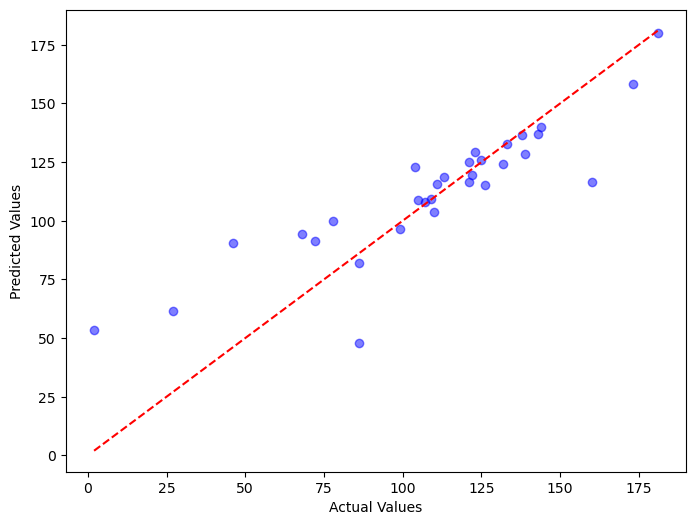

In [ ]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor

# --- Preprocessing and Held-Out Test Split ---

# (Assume your DataFrame is already loaded as 'df')
if "Element" in df.columns:
    df = df.drop(columns=["Element"])

target_column = "DC"
feature_names = df.drop(columns=[target_column]).columns.tolist()

scaler = StandardScaler()
X_full = scaler.fit_transform(df.drop(columns=[target_column]).to_numpy())
y_full = df[target_column].to_numpy()

y_full_binned = pd.qcut(y_full, q=10, duplicates='drop', labels=False)

X_train_val, X_test, y_train_val, y_test, y_train_val_binned, _ = train_test_split(
    X_full, y_full, y_full_binned, test_size=0.15, random_state=42, stratify=y_full_binned
)

# --- Define the Objective Function with Stratified K-Fold CV ---

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = []
    
    for train_index, val_index in skf.split(X_train_val, y_train_val_binned):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
        
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train_fold, y_train_fold)
        
        preds = model.predict(X_val_fold)
        r_squared = r2_score(y_val_fold, preds)
        r2_scores.append(r_squared)
    
    return np.mean(r2_scores)

# --- Hyperparameter Optimization using Optuna ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# --- Final Model Training on Full Training Data ---
best_model = RandomForestRegressor(
    n_estimators=study.best_params["n_estimators"],
    max_depth=study.best_params["max_depth"],
    min_samples_split=study.best_params["min_samples_split"],
    min_samples_leaf=study.best_params["min_samples_leaf"],
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_train_val, y_train_val)

y_pred = best_model.predict(X_test)

# Compute evaluation metrics
n = len(y_test)
p = X_test.shape[1]
metrics = {
    "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred),
    "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
    "Mean Absolute Error (MAE)": mean_absolute_error(y_test, y_pred),
    "R² Score": r2_score(y_test, y_pred),
    "Adjusted R² Score": 1 - (1 - r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)
}

print("Evaluation Metrics:")
print(metrics)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.savefig("Regresssion_RF.png")
plt.show()

## Gradient Boosting Regressor

[I 2025-03-23 21:21:04,746] A new study created in memory with name: no-name-ea9b3623-7f26-4ce8-8e9e-e5eeb15dcf70
[I 2025-03-23 21:21:06,423] Trial 0 finished with value: 0.013031995720333645 and parameters: {'n_estimators': 419, 'learning_rate': 0.9199273331345297, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.013031995720333645.
[I 2025-03-23 21:21:07,144] Trial 1 finished with value: 0.3415297360826698 and parameters: {'n_estimators': 312, 'learning_rate': 0.41899729257504353, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.3415297360826698.
[I 2025-03-23 21:21:08,402] Trial 2 finished with value: 0.3317351568275549 and parameters: {'n_estimators': 326, 'learning_rate': 0.30695835476265626, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.3415297360826698.
[I 2025-03-23 21:21:10,090] Trial 3 finished with value: 0.36972177665097705 and parameter

CSV test file saved successfully!
Evaluation Metrics:
{'Mean Squared Error (MSE)': 274.1625468451464, 'Root Mean Squared Error (RMSE)': 16.55785453629625, 'Mean Absolute Error (MAE)': 11.09810747615112, 'R² Score': 0.7813220369991951, 'Adjusted R² Score': 0.6355367283319919}


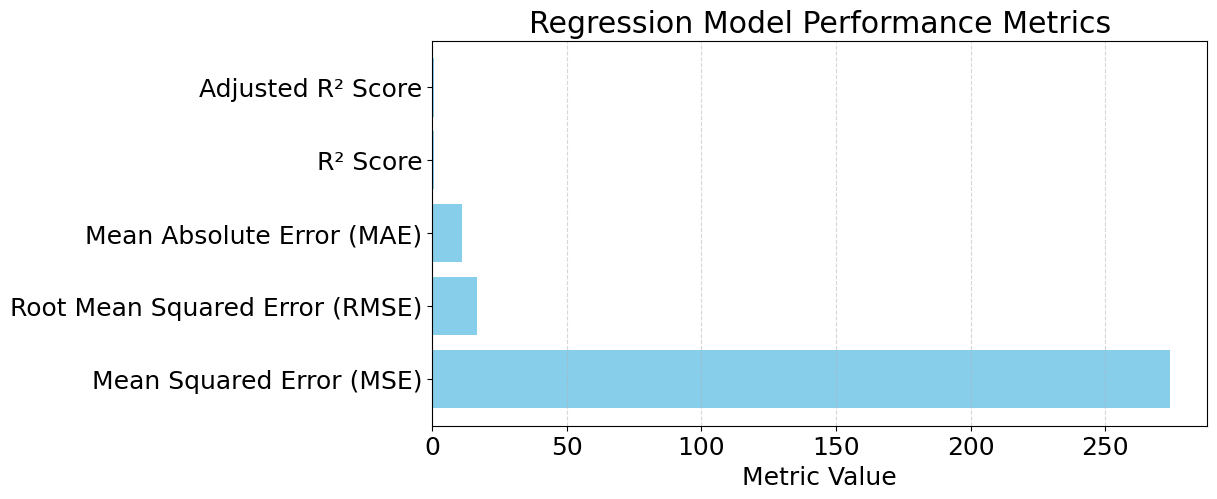

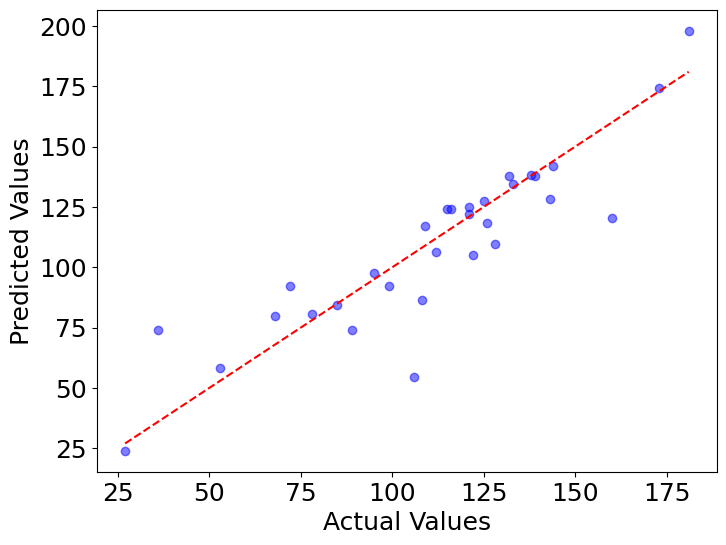

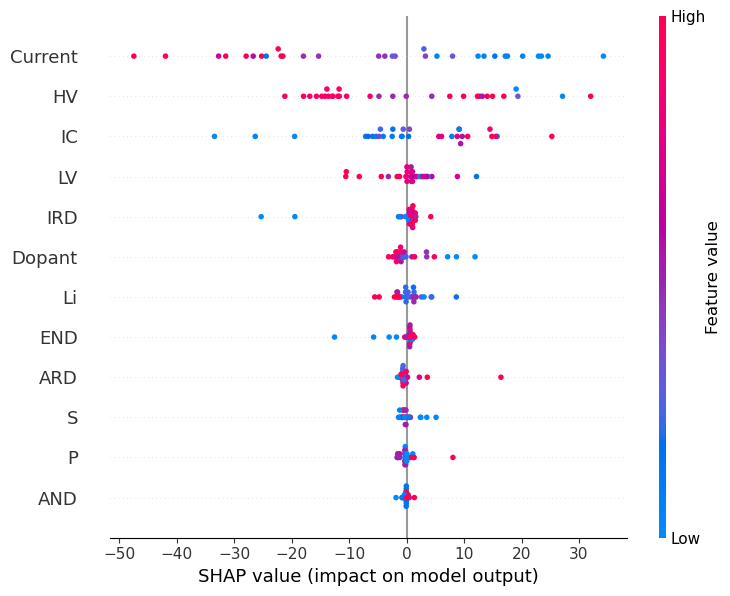

In [ ]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
import shap

# --- Preprocessing and Held-Out Test Split ---

# (Assume your DataFrame is already loaded as 'df')
if "Element" in df.columns:
    df = df.drop(columns=["Element"])

target_column = "DC"
feature_names = df.drop(columns=[target_column]).columns.tolist()

X_full = df.drop(columns=[target_column]).to_numpy()
y_full = df[target_column].to_numpy()

y_full_binned = pd.qcut(y_full, q=10, duplicates='drop', labels=False)

X_train_val, X_test, y_train_val, y_test, y_train_val_binned, _ = train_test_split(
    X_full, y_full, y_full_binned, test_size=0.15, random_state=42, stratify=y_full_binned
)

# --- Define the Objective Function with Stratified K-Fold CV ---

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = []
    
    for train_index, val_index in skf.split(X_train_val, y_train_val_binned):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
        
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)
        
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        model.fit(X_train_fold_scaled, y_train_fold)
        
        preds = model.predict(X_val_fold_scaled)
        r_squared = r2_score(y_val_fold, preds)
        r2_scores.append(r_squared)
    
    return np.mean(r2_scores)

# --- Hyperparameter Optimization using Optuna ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# --- Final Model Training on Full Training Data ---
scaler_final = StandardScaler()
X_train_val_scaled = scaler_final.fit_transform(X_train_val)
X_test_scaled = scaler_final.transform(X_test)

best_model = GradientBoostingRegressor(
    n_estimators=study.best_params["n_estimators"],
    learning_rate=study.best_params["learning_rate"],
    max_depth=study.best_params["max_depth"],
    min_samples_split=study.best_params["min_samples_split"],
    min_samples_leaf=study.best_params["min_samples_leaf"],
    random_state=42
)
best_model.fit(X_train_val_scaled, y_train_val)

y_pred = best_model.predict(X_test_scaled)

output_df = pd.DataFrame({'ground_truth': y_test, 'prediction': y_pred})
output_df.to_csv('output.csv', index=False)
print('CSV test file saved successfully!')

n = X_test.shape[0]
p = X_test.shape[1]

metrics = {
    "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred),
    "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
    "Mean Absolute Error (MAE)": mean_absolute_error(y_test, y_pred),
    "R² Score": r2_score(y_test, y_pred),
    "Adjusted R² Score": 1 - (1 - r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)
}

print("Evaluation Metrics:")
print(metrics)

plt.figure(figsize=(10, 5))
plt.barh(list(metrics.keys()), list(metrics.values()), color='skyblue')
plt.xlabel("Metric Value")
plt.title("Regression Model Performance Metrics")
plt.grid(axis='x', linestyle="--", alpha=0.5)
plt.savefig("Metric_Values_Test.png")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.savefig("Regresssion_GBR.png")
plt.show()

# --- SHAP Value Analysis ---
shap.initjs()
explainer = shap.Explainer(best_model, X_train_val_scaled)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

## Kernal Lasso Regression

[I 2025-03-23 21:23:22,953] A new study created in memory with name: no-name-ef829105-0d68-48ba-8c0d-5e3e41fba85e
c:\Users\nurea\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\Users\nurea\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\Users\nurea\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\Users\nurea\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\Users\nurea\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. U

Evaluation Metrics:
{'Mean Squared Error (MSE)': 359.0805057439531, 'Root Mean Squared Error (RMSE)': 18.94941966773529, 'Mean Absolute Error (MAE)': 13.266620719294334, 'R² Score': 0.7135896406968449, 'Adjusted R² Score': 0.5226494011614082}


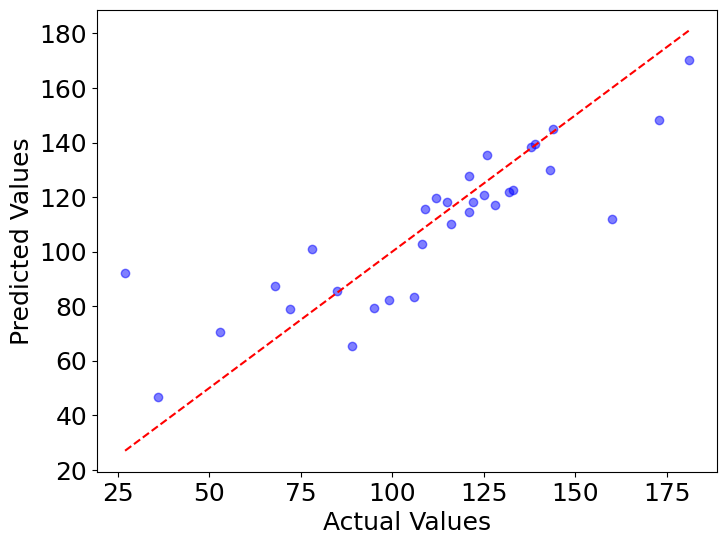

In [ ]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.kernel_ridge import KernelRidge

# --- Preprocessing and Held-Out Test Split ---

# (Assume your DataFrame is already loaded as 'df')
if "Element" in df.columns:
    df = df.drop(columns=["Element"])

target_column = "DC"
feature_names = df.drop(columns=[target_column]).columns.tolist()

scaler = StandardScaler()
X_full = scaler.fit_transform(df.drop(columns=[target_column]).to_numpy())
y_full = df[target_column].to_numpy()

y_full_binned = pd.qcut(y_full, q=10, duplicates='drop', labels=False)

X_train_val, X_test, y_train_val, y_test, y_train_val_binned, _ = train_test_split(
    X_full, y_full, y_full_binned, test_size=0.15, random_state=42, stratify=y_full_binned
)

# --- Define the Objective Function with Stratified K-Fold CV ---

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-2, 100.0, log=True)  # Increased min alpha for stability
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    gamma = trial.suggest_float("gamma", 1e-3, 10.0, log=True)  # Adjusted range to prevent instability
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = []
    
    for train_index, val_index in skf.split(X_train_val, y_train_val_binned):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
        
        model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma)
        model.fit(X_train_fold + 1e-6 * np.random.randn(*X_train_fold.shape), y_train_fold)  # Additive noise for stability
        
        preds = model.predict(X_val_fold)
        r_squared = r2_score(y_val_fold, preds)
        r2_scores.append(r_squared)
    
    return np.mean(r2_scores)

# --- Hyperparameter Optimization using Optuna ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# --- Final Model Training on Full Training Data ---
best_model = KernelRidge(
    alpha=study.best_params["alpha"],
    kernel=study.best_params["kernel"],
    gamma=study.best_params["gamma"]
)
best_model.fit(X_train_val + 1e-6 * np.random.randn(*X_train_val.shape), y_train_val)  # Add noise for stability

y_pred = best_model.predict(X_test)

# Compute evaluation metrics
n = len(y_test)
p = X_test.shape[1]
metrics = {
    "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred),
    "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
    "Mean Absolute Error (MAE)": mean_absolute_error(y_test, y_pred),
    "R² Score": r2_score(y_test, y_pred),
    "Adjusted R² Score": 1 - (1 - r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)
}

print("Evaluation Metrics:")
print(metrics)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.savefig("Regresssion_KLR.png")
plt.show()